In [10]:
import numpy as np
import cv2
import torch
import glob as glob

from model import create_model
from config import NUM_CLASSES, RESIZE_TO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
new_model = create_model(num_classes = NUM_CLASSES).to(device)

new_model.load_state_dict(torch.load(
    'outputs/model.pth', map_location=device
))

<All keys matched successfully>

Test instances: 8
[0.570146   0.54470587 0.504075   0.50125617 0.4950029  0.49342304
 0.48927385 0.4853476  0.48525697 0.47937983 0.4777505  0.4772855
 0.47708085 0.47694755 0.47662106 0.47289497 0.47247264 0.471968
 0.4696761  0.46812055 0.46739992 0.46690124 0.4652004  0.45924905
 0.45649555 0.45071054 0.45005125 0.44792697 0.44608998 0.44601437
 0.4456455  0.44541568 0.44015172 0.43878832 0.43856797 0.43479857
 0.43265378 0.43171352 0.43117118 0.43109572 0.43026495 0.4238401
 0.42279497 0.4218185  0.42001036 0.41838023 0.41693962 0.41661176
 0.41396964 0.41279724 0.41165182 0.41083607 0.40964288 0.40624246
 0.40560025 0.40468478 0.4001318  0.3981661  0.39786673 0.3936881
 0.39285663 0.39247766 0.39120737 0.39002457 0.38987172 0.38929152
 0.3864444  0.38447452 0.38285384 0.38271824 0.3819652  0.37960643
 0.3790397  0.3780939  0.37763193 0.3766733  0.37653995 0.37559506
 0.37464583 0.3739957  0.37377667 0.37356797 0.37314484 0.37312022
 0.37247273 0.3718203  0.37026972 0.36978668 0.36

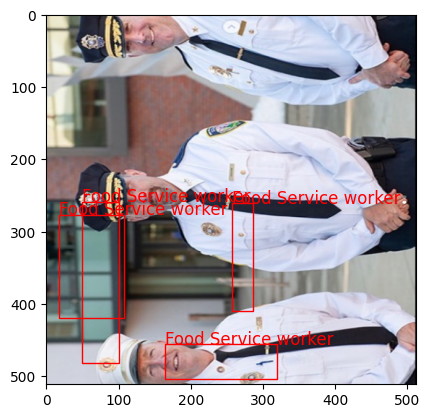

[0.5335572  0.50833017 0.49621618 0.49062982 0.49051628 0.48694736
 0.47424254 0.47144747 0.470454   0.46983737 0.46957284 0.46607214
 0.46371838 0.46187684 0.46169528 0.46157897 0.45283425 0.45122108
 0.44948122 0.4428773  0.44219798 0.43902773 0.43733191 0.4344593
 0.4333032  0.4331166  0.4316728  0.42932963 0.42841592 0.4265424
 0.4245021  0.42444462 0.42400572 0.42104897 0.41810602 0.41782677
 0.41762993 0.4173771  0.41385877 0.41370347 0.41007134 0.40841153
 0.4083577  0.4062826  0.40532157 0.4052751  0.40343067 0.40210035
 0.40194446 0.40079    0.3997036  0.3988762  0.39779708 0.396745
 0.396255   0.39575073 0.3953045  0.39510572 0.39498582 0.39463896
 0.39325038 0.39280942 0.3927549  0.3925157  0.3907905  0.3855173
 0.3852311  0.38513345 0.38409987 0.38334027 0.38209385 0.3819156
 0.3811839  0.38105154 0.37838325 0.37763426 0.37726963 0.37550634
 0.37454775 0.37422112 0.37387687 0.37351522 0.37336043 0.37124366
 0.37097695 0.3698459  0.3684325  0.36727342 0.36668152 0.36548153
 

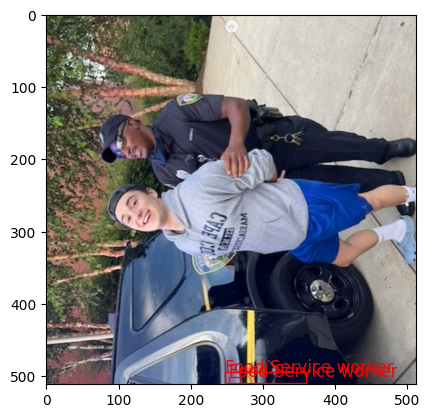

[0.5607256  0.55783725 0.5232778  0.5159929  0.4915998  0.49087614
 0.48648727 0.48312613 0.4802264  0.47340575 0.47057578 0.46957305
 0.46930474 0.46784547 0.46559694 0.46343565 0.46301442 0.45996207
 0.45771405 0.45145634 0.44899267 0.44696078 0.4460665  0.43970138
 0.4376833  0.43649736 0.43187368 0.42884403 0.42806488 0.42733815
 0.4216556  0.42060834 0.4199631  0.4183483  0.41817036 0.41555008
 0.4142079  0.41196725 0.40845156 0.40833488 0.4073933  0.40387473
 0.40371412 0.4028649  0.40251687 0.40158236 0.40029323 0.4001357
 0.39964524 0.39730301 0.39401567 0.39347625 0.39330563 0.39311385
 0.39309233 0.3878941  0.3843732  0.3840726  0.38005242 0.37731943
 0.37678757 0.37564257 0.37558997 0.37470433 0.37267265 0.36991963
 0.36948314 0.36762282 0.36743766 0.36712545 0.3666673  0.3645827
 0.36437848 0.36369035 0.36365184 0.36363697 0.36281118 0.36240602
 0.36234948 0.3620749  0.3611672  0.36048368 0.35763136 0.35674423
 0.35612988 0.35467437 0.3543984  0.35384434 0.352528   0.350540

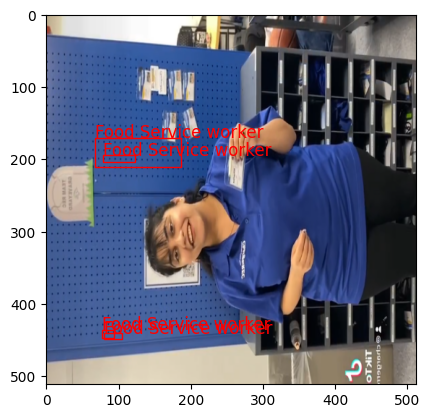

[0.48109227 0.46648175 0.4470361  0.44514364 0.44323316 0.44137526
 0.44079778 0.4368057  0.43664914 0.42046124 0.4195783  0.41824314
 0.41586107 0.41447172 0.41168293 0.4060538  0.40344957 0.40194342
 0.39969322 0.39939874 0.39734495 0.39673227 0.39576527 0.39359763
 0.39278445 0.39082038 0.39029688 0.3864113  0.38452762 0.3843341
 0.38149616 0.3806616  0.37995228 0.37643915 0.37582272 0.37261635
 0.3721319  0.3695452  0.36876056 0.36831906 0.36817273 0.36782208
 0.36755404 0.3664256  0.3662968  0.36538616 0.36483216 0.36262053
 0.36072126 0.35964736 0.35862458 0.35787964 0.3576814  0.3573565
 0.35625446 0.35522306 0.3543442  0.35429442 0.35385212 0.35307142
 0.35237554 0.35212076 0.3517825  0.34888187 0.3480358  0.34774327
 0.34462154 0.34383464 0.343419   0.34315488 0.34247598 0.34143114
 0.34122542 0.33996218 0.3391859  0.3391386  0.3384266  0.3374943
 0.33725694 0.33585417 0.33564922 0.33522326 0.3348622  0.33444235
 0.3339135  0.33383077 0.33287543 0.3326738  0.33184537 0.3317353

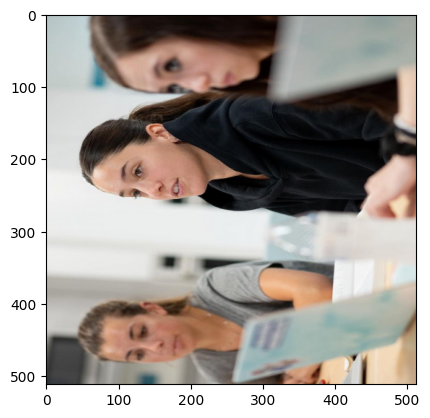

[0.49274197 0.48834267 0.4827284  0.47895497 0.47457132 0.45511606
 0.4547407  0.4475121  0.44526663 0.4393628  0.4331809  0.43084574
 0.42924646 0.42525983 0.42150447 0.41636372 0.4153945  0.41477415
 0.41402188 0.40924177 0.40603828 0.4055398  0.40488982 0.40442103
 0.3965264  0.3948107  0.39115044 0.39083627 0.38563204 0.38560915
 0.38520232 0.38383627 0.38201877 0.37949872 0.3792723  0.37749094
 0.37536544 0.37395048 0.3737702  0.37331092 0.37067693 0.3704133
 0.3702296  0.37004495 0.36767438 0.36670786 0.36319026 0.36200228
 0.35787198 0.35712922 0.357072   0.3539874  0.35394013 0.3535125
 0.35324806 0.35200942 0.35145357 0.35095906 0.34989464 0.34870166
 0.34703934 0.34627047 0.3460407  0.34599802 0.34541935 0.3439783
 0.34387818 0.3432147  0.34312215 0.34223688 0.34207752 0.3418134
 0.3404278  0.34000233 0.33976078 0.3390619  0.33832586 0.338143
 0.33581847 0.33502933 0.3347064  0.33466423 0.33376274 0.33359325
 0.33117488 0.33074507 0.33056012 0.3291582  0.32753205 0.32718167
 

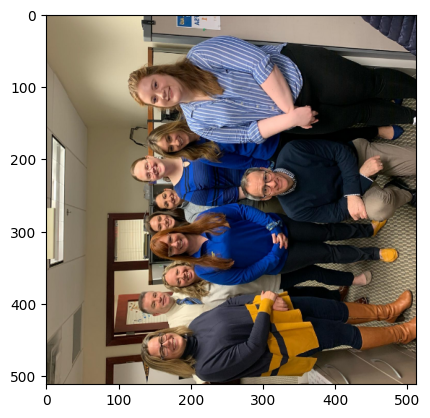

[0.51925737 0.51871234 0.5006189  0.50005436 0.49373412 0.4878715
 0.48737156 0.48692095 0.48650235 0.4858736  0.48381025 0.48218748
 0.4750725  0.4692654  0.46545538 0.46477976 0.4636866  0.46319842
 0.4625727  0.4620023  0.46061915 0.45519108 0.45377013 0.44718993
 0.4458612  0.4453661  0.4433729  0.4408902  0.43992704 0.43890974
 0.437699   0.43705717 0.43672284 0.43507004 0.43395707 0.42925027
 0.42871144 0.4286295  0.42806235 0.4279653  0.4278443  0.42780706
 0.42752868 0.42699453 0.42593858 0.42563906 0.424141   0.42398185
 0.42322576 0.4207502  0.42073485 0.41992804 0.41903022 0.4187772
 0.41874212 0.4180528  0.41670126 0.4163476  0.41354507 0.41205072
 0.4106632  0.41003022 0.408793   0.40865052 0.4076727  0.40639707
 0.40583614 0.40424833 0.4021006  0.40178135 0.39993683 0.39944133
 0.39933673 0.3991018  0.39892447 0.39832056 0.39824253 0.39646184
 0.39578712 0.3946101  0.3944519  0.39428496 0.3942218  0.39398515
 0.39323822 0.39236638 0.3917243  0.39098802 0.39098442 0.390679

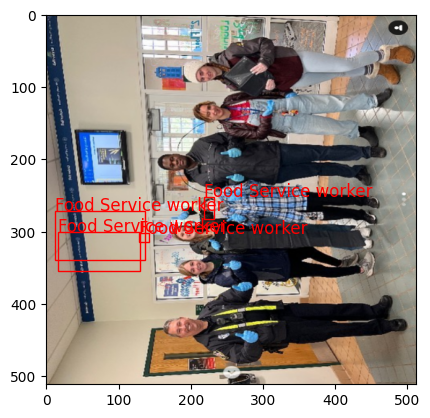

[0.47177497 0.43707252 0.42833602 0.42226595 0.42113328 0.41456363
 0.41392455 0.41286865 0.39939842 0.39753202 0.39572707 0.39365306
 0.3877265  0.38434216 0.38258606 0.37839204 0.37828016 0.3753402
 0.37524724 0.3733545  0.3731375  0.3724808  0.3678608  0.3662318
 0.36182666 0.3606492  0.36038455 0.3578279  0.35723075 0.35624403
 0.35543203 0.35428637 0.35141686 0.3504339  0.35007536 0.34971175
 0.34942463 0.34893596 0.3469707  0.34608585 0.3454406  0.345147
 0.3450802  0.34426185 0.34422088 0.3428255  0.34254742 0.34187058
 0.3411061  0.34037963 0.34037742 0.3388917  0.33715445 0.33643347
 0.33540338 0.33442318 0.33405364 0.33304852 0.33234978 0.33125067
 0.33123955 0.33107686 0.33100164 0.33087265 0.33065343 0.33009014
 0.3279853  0.32757246 0.3275682  0.3263292  0.32582283 0.32488292
 0.32456493 0.323705   0.3227626  0.32275462 0.32252637 0.32216668
 0.32181013 0.32064372 0.31930473 0.3182689  0.3169226  0.31683335
 0.31679899 0.3166068  0.31637216 0.316016   0.3157562  0.31547478

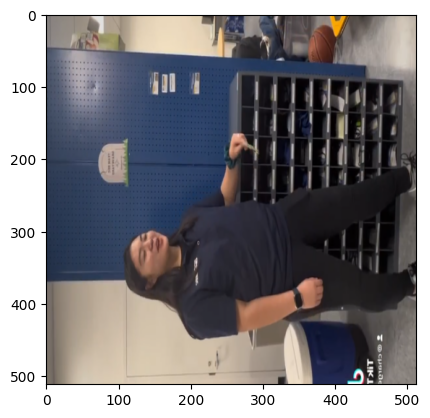

[0.5181349  0.5136647  0.5024761  0.49704808 0.49405605 0.49285164
 0.4829591  0.4704974  0.4662647  0.4566747  0.45465374 0.45448166
 0.44940042 0.44525218 0.44334468 0.43834454 0.43586874 0.43295962
 0.42731014 0.42642835 0.42548987 0.42465806 0.4246551  0.42189685
 0.42059165 0.4191579  0.41774422 0.4166405  0.4163106  0.41617882
 0.41575596 0.41485468 0.41381788 0.41162363 0.41082752 0.40931624
 0.4067441  0.4057153  0.40543848 0.40347522 0.3997054  0.3959817
 0.39584354 0.39498627 0.3946865  0.39463246 0.39241862 0.39177355
 0.3896869  0.38783133 0.386609   0.38637915 0.38572484 0.38388065
 0.38272172 0.38034186 0.3792363  0.37644166 0.376433   0.37586907
 0.37562653 0.37515685 0.37467715 0.37467012 0.37408343 0.373682
 0.37302732 0.37276843 0.37187153 0.37060753 0.37053275 0.36941186
 0.3679175  0.36720073 0.3671995  0.367001   0.36674696 0.36419573
 0.36322555 0.36116415 0.36114684 0.36066422 0.36039877 0.35991055
 0.35949188 0.35938627 0.3591431  0.35893553 0.3584363  0.3581443

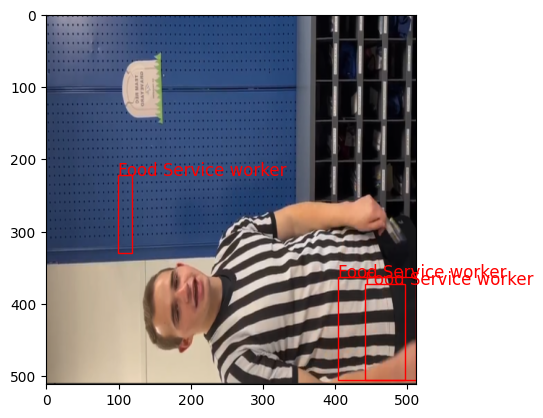

In [16]:
model.eval()

# directory where all the images are present
DIR_TEST = 'dataset/test'
test_images = glob.glob(f"{DIR_TEST}/*.png")
print(f"Test instances: {len(test_images)}")

test_images = test_images[:8]

# classes: 0 index is reserved for background
CLASSES = [
    'student','Security', 'Staff', 'Facility Worker','Food Service worker'
]

# define the detection threshold...
# ... any detection having score below this will be discarded
# detection_threshold = 0.8

